## Have a look at this dataset of [emails from Canadian political parties](https://datasetsearch.research.google.com/search?query=email%20canadian&docid=L2cvMTFuZzZuNWZjOQ%3D%3D) (Emails from Canadian Federal Political Parties- there are 8 datasets in 3 formats each,)

1. Consider the email body text, and identify people talked about in these emails

2. Output should include usable or insightful elements
E.g.:
- A function that can be called with text that emits the people's names in the text
- A data frame with each of the mentions, (&date / sending-party)
- Weekly aggregate of the data / plot time frequency of mentions (split by party.)
- Etc. (i.e. if you want to do something else with these emails)


In [2]:
# suppress warnings
import warnings;
warnings.filterwarnings('ignore');

# common imports
import pandas as pd
import numpy as np
import math
import re
import glob
import os
import sys
import json
import random
import pprint as pp
import textwrap
import sqlite3
import logging

import spacy

!pip install stanza
import stanza

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import string
import re
from collections import Counter

from tqdm.auto import tqdm
# register `pandas.progress_apply` and `pandas.Series.map_apply` with `tqdm`
tqdm.pandas()

# pandas display options
# https://pandas.pydata.org/pandas-docs/stable/user_guide/options.html#available-options
pd.options.display.max_columns = 30 # default 20
pd.options.display.max_rows = 60 # default 60
pd.options.display.float_format = '{:.2f}'.format
# pd.options.display.precision = 2
pd.options.display.max_colwidth = 200 # default 50; -1 = all
# otherwise text between $ signs will be interpreted as formula and printed in italic
pd.set_option('display.html.use_mathjax', False)

# np.set_printoptions(edgeitems=3) # default 3

import matplotlib
from matplotlib import pyplot as plt

plot_params = {'figure.figsize': (8, 4), 
               'axes.labelsize': 'large',
               'axes.titlesize': 'large',
               'xtick.labelsize': 'large',
               'ytick.labelsize':'large',
               'figure.dpi': 100}
# adjust matplotlib defaults
matplotlib.rcParams.update(plot_params)

import seaborn as sns
sns.set_style("darkgrid")



import xml.etree.cElementTree as ET



     |████████████████████████████████| 342 kB 13.2 MB/s 


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Preparation
1. Parsing XML function
2. Dataset Files preparation
3. Export the dataset into Datframe

In [5]:
# Parsing XML file function, return the information list

def extract_xml_from_file(file_path,email_file):
#  ------------------------------------------------
#  Function: Extract information from XML files
#  Input: File path and File Name (string)
#  Output: list
#  ------------------------------------------------
    
    if email_file =='' or file_path =='':
        return
    
    
    
    msg_item = []
    messages_list = []

    msg_date = ''
    msg_from_name = ''
    msg_from_email = ''
    msg_text = ''


    tree=ET.parse(file_path + email_file)
    root=tree.getroot()
    for child in root:
    
        if child.tag =='message':
        
            for sub in child:
            
                if sub.tag == 'received':
                    for ssub in sub:
                        if ssub.tag == 'date':
                            msg_date = ssub.text
                        
                if sub.tag == 'from':
                    for ssub in sub:
                        if ssub.tag == 'name':
                            msg_from_name = ssub.text     
                        if ssub.tag == 'email':
                            msg_from_email = str(ssub.text)
                
                if sub.tag == 'text':
                    msg_text = sub.text
                msg_item = [msg_date,msg_from_name,msg_from_email,msg_text]
            messages_list.append(msg_item)
    
    return messages_list  

In [6]:
# parsing all dataset files by using MANIFEST.TXT and export into dataframe

path  = '/content/drive/My Drive/Projects/sedna/dataverse_files/'
manifest_file = path + 'MANIFEST.TXT'
email_all_list = []

manifest_file_df = pd.read_csv(manifest_file, sep=" ",header=None,names=['file_name','type','size','size_unit'])
email_file_list = manifest_file_df['file_name'].to_list()
for i in range(len(email_file_list)):
    email_all_list += extract_xml_from_file(path,email_file_list[i])
   
   
df = pd.DataFrame(email_all_list,columns=['date','message_from_name','message_from_email','email_text']) 

      

In [7]:
df

,date,message_from_name,message_from_email,email_text
0,20140920,Jaime Girard,info@conservative.ca,
1,20141023,Conservative Party of Canada,info@conservative.ca,"http://www.conservative.ca\nSpeech from Prime Minister Stephen Harper:\n\nMy fellow Canadians, for the second time this week there has been a brutal and\nviolent attack on our soil.\n\nToday, our ..."
2,20141030,"Jaime Girard, Conservative Party of Canada",info@conservative.ca,"https://donate.conservative.ca/MembershipDrive?mpi=415bbada7d&vpi=a&utm_source=unknow\nn&utm_medium=email&utm_campaign=membershipdrive\nFriend,\n\nThe Conservative Party, like no other party, is d..."
3,20141031,"Erin O'Toole, MP",info@conservative.ca,"http://www.conservative.ca/NewTaxBreaks/\nFriend,\n\nAs a father to two amazing young children, I can’t tell you how excited my wife and I\nare about what Prime Minister Stephen Harper announced t..."
4,20141031,Conservative Party of Canada,info@conservative.ca,https://donate.conservative.ca?mpi=c4864059e7&vpi=a&utm_medium=email&utm_campaign=hal\nloween\nhttps://donate.conservative.ca?mpi=c4864059e7&vpi=b&utm_medium=email&utm_campaign=hal\nloween\nhttps:...
...,...,...,...,...
4709,20171024,Andrea Bass,info@ndp.ca,"\t\t\n \n\nMichael,\n\nAre you a first time volunteer or a seasoned veteran? Excited about knocking doors or\nready to be a social media influencer?\n\nOur upcoming training sessions will have ..."
4710,20171025,Robert Fox,info@ndp.ca,"\t\t\n \n\nMichael,\n\nLast week, I heard from thousands of people who want to be involved in the change\nJagmeet is making. But it was also a hard week, Michael.\n\nOur motion to introduce uni..."
4711,20171028,Marit Stiles,info@ndp.ca,"\t\t\n \n\n\nMichael,\n\nSomething amazing has been happening these past few weeks - not only is our movement\ngrowing, but it's bringing people together.\n\nNew members are telling me that this ..."
4712,20171101,Jamie Masse,info@ndp.ca,"\t\t\n \n\n\nMichael,\n\nWhen we lost our public funding, it felt like the rug was pulled out from under us.\nBut New Democrats stepped up - you chipped in what you could so we could rebuild and\..."


## Person NER detection
- Build person NER detection function, input is the text, return the person name list
- NLP library : [Stanza](https://stanfordnlp.github.io/stanza/)
- more discusiions about Stanza vs SpaCy are in the appendix 

In [9]:
stanza.download('en')  
nlp_stan = stanza.Pipeline(lang='en', processors='tokenize,ner')

2021-10-04 14:18:58 INFO: Downloading default packages for language: en (English)...


2021-10-04 14:20:21 INFO: Finished downloading models and saved to /root/stanza_resources.
2021-10-04 14:20:21 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | combined  |
| ner       | ontonotes |

2021-10-04 14:20:21 INFO: Use device: gpu
2021-10-04 14:20:21 INFO: Loading: tokenize
2021-10-04 14:20:30 INFO: Loading: ner
2021-10-04 14:20:31 INFO: Done loading processors!


In [10]:
# person name NER detection function

def person_NER_detection(text):

# ----------------------------------------
#   Function: person name NER detection
#   Input: text (string)
#   Output: list with person names or null


    if text == '':
        return []
        
    doc = nlp_stan(text)
 
    mentioned_stan=[]
    
    for sent in doc.sentences:
        for ent in sent.ents:
            if ent.type =='PERSON':
                
                mentioned_stan +=[ent.text.replace('\n',' ')]
    ## list(dict.fromkeys(mentioned_stan))  for non-redundency
    return mentioned_stan
    
    

## Create Person Mentioned Dataframe
- apply person_NER_detection function into email text dataframe
- re-construct dataframe based on mentioned person names

In [11]:
# apply person_NER_detection function into email text dataframe
df['email_mentioned_person'] = df['email_text'].apply(lambda x: person_NER_detection(x))

In [12]:
df.head()
    

,date,message_from_name,message_from_email,email_text,email_mentioned_person
0,20140920,Jaime Girard,info@conservative.ca,,[]
1,20141023,Conservative Party of Canada,info@conservative.ca,"http://www.conservative.ca\nSpeech from Prime Minister Stephen Harper:\n\nMy fellow Canadians, for the second time this week there has been a brutal and\nviolent attack on our soil.\n\nToday, our ...","[Stephen Harper, Nathan Cirillo, Cirillo, Patrice Vincent, Cirillo, Laureen, Ben, Rachel]"
2,20141030,"Jaime Girard, Conservative Party of Canada",info@conservative.ca,"https://donate.conservative.ca/MembershipDrive?mpi=415bbada7d&vpi=a&utm_source=unknow\nn&utm_medium=email&utm_campaign=membershipdrive\nFriend,\n\nThe Conservative Party, like no other party, is d...",[Jaime Girard]
3,20141031,"Erin O'Toole, MP",info@conservative.ca,"http://www.conservative.ca/NewTaxBreaks/\nFriend,\n\nAs a father to two amazing young children, I can’t tell you how excited my wife and I\nare about what Prime Minister Stephen Harper announced t...","[Stephen Harper, Dad, Erin O’Toole MP]"
4,20141031,Conservative Party of Canada,info@conservative.ca,https://donate.conservative.ca?mpi=c4864059e7&vpi=a&utm_medium=email&utm_campaign=hal\nloween\nhttps://donate.conservative.ca?mpi=c4864059e7&vpi=b&utm_medium=email&utm_campaign=hal\nloween\nhttps:...,[]


In [61]:
email_mention_df = df[['date','message_from_name','message_from_email','email_mentioned_person']]

In [62]:
email_mention_df.head()

,date,message_from_name,message_from_email,email_mentioned_person
0,20140920,Jaime Girard,info@conservative.ca,[]
1,20141023,Conservative Party of Canada,info@conservative.ca,"[Stephen Harper, Nathan Cirillo, Cirillo, Patrice Vincent, Cirillo, Laureen, Ben, Rachel]"
2,20141030,"Jaime Girard, Conservative Party of Canada",info@conservative.ca,[Jaime Girard]
3,20141031,"Erin O'Toole, MP",info@conservative.ca,"[Stephen Harper, Dad, Erin O’Toole MP]"
4,20141031,Conservative Party of Canada,info@conservative.ca,[]


In [63]:
len(email_mention_df)

4714

In [64]:
# re-construct dataframe based on mentioned person names
target_col = 'email_mentioned_person'

mentioned_person_df = pd.DataFrame({
      col:np.repeat(email_mention_df[col].values, email_mention_df[target_col].str.len())
      for col in email_mention_df.columns.drop(target_col)}
    ).assign(**{target_col:np.concatenate(email_mention_df[target_col].values)})[email_mention_df.columns]

In [65]:
mentioned_person_df

,date,message_from_name,message_from_email,email_mentioned_person
0,20141023,Conservative Party of Canada,info@conservative.ca,Stephen Harper
1,20141023,Conservative Party of Canada,info@conservative.ca,Nathan Cirillo
2,20141023,Conservative Party of Canada,info@conservative.ca,Cirillo
3,20141023,Conservative Party of Canada,info@conservative.ca,Patrice Vincent
4,20141023,Conservative Party of Canada,info@conservative.ca,Cirillo
...,...,...,...,...
20178,20171101,Jamie Masse,info@ndp.ca,Michael
20179,20171101,Jamie Masse,info@ndp.ca,Michael
20180,20171101,Jamie Masse,info@ndp.ca,Michael
20181,20171101,Jamie Masse,info@ndp.ca,Jamie


In [66]:
len(mentioned_person_df)

20183

In [67]:
# extract part name
def extract_party_name(text):

  if 'conservative.ca' in text:
    return 'Conservative Party'
  if 'ndp.ca' in text:
    return 'NDP'
  if 'liberal.ca' in text:
    return 'Liberal Party'


In [68]:
mentioned_person_df['email_from_party'] = mentioned_person_df['message_from_email'].apply(lambda x: extract_party_name(x))

In [69]:
mentioned_person_df['date'] = pd.to_datetime(mentioned_person_df['date'], format='%Y%m%d')


In [70]:
mentioned_person_df.drop(['message_from_email'], inplace=True, axis=1)
mentioned_person_df

,date,message_from_name,email_mentioned_person,email_from_party
0,2014-10-23,Conservative Party of Canada,Stephen Harper,Conservative Party
1,2014-10-23,Conservative Party of Canada,Nathan Cirillo,Conservative Party
2,2014-10-23,Conservative Party of Canada,Cirillo,Conservative Party
3,2014-10-23,Conservative Party of Canada,Patrice Vincent,Conservative Party
4,2014-10-23,Conservative Party of Canada,Cirillo,Conservative Party
...,...,...,...,...
20178,2017-11-01,Jamie Masse,Michael,NDP
20179,2017-11-01,Jamie Masse,Michael,NDP
20180,2017-11-01,Jamie Masse,Michael,NDP
20181,2017-11-01,Jamie Masse,Jamie,NDP


In [50]:
# Save the dataframe into csv
mentioned_person_df.to_csv('/content/drive/My Drive/Projects/sedna/email_mentioned_person.csv', sep='\t', encoding='utf-8')

## Data Analysis and Plot
- Split data by party
- plot weekly mentioned data
- plot top 20 mentioned persons in different parties

In [81]:
# Split the data based on party name
grouped_df = mentioned_person_df.groupby(mentioned_person_df.email_from_party)

In [82]:
cp_df = grouped_df.get_group('Conservative Party')
lib_df = grouped_df.get_group('Liberal Party')
ndp_df = grouped_df.get_group('NDP')

In [83]:
cp_df

,date,message_from_name,email_mentioned_person,email_from_party,WeekDate
0,2014-10-16,Conservative Party of Canada,Stephen Harper,Conservative Party,2014-10-13
1,2014-10-16,Conservative Party of Canada,Nathan Cirillo,Conservative Party,2014-10-13
2,2014-10-16,Conservative Party of Canada,Cirillo,Conservative Party,2014-10-13
3,2014-10-16,Conservative Party of Canada,Patrice Vincent,Conservative Party,2014-10-13
4,2014-10-16,Conservative Party of Canada,Cirillo,Conservative Party,2014-10-13
...,...,...,...,...,...
6770,2017-10-27,CPC Digital Dept.,John,Conservative Party,2017-10-23
6771,2017-10-27,CPC Digital Dept.,Justin Trudeau,Conservative Party,2017-10-23
6772,2017-10-27,CPC Digital Dept.,Bill Morneau,Conservative Party,2017-10-23
6773,2017-10-27,CPC Digital Dept.,Andrew Scheer,Conservative Party,2017-10-23


### Create weekly data and plot top 20 mentioned person based on different parties

-  Conservative Party Data

In [85]:

import datetime as dt


cp_df['WeekDate'] =cp_df.apply(lambda row: row['date'] - dt.timedelta(days=row['date'].weekday()), axis=1)

cp_perweek = cp_df['WeekDate'].groupby(cp_df['WeekDate']).count()
cp_perweek

WeekDate
2014-09-15     2
2014-09-22    19
2014-09-29    18
2014-10-06    11
2014-10-13    24
              ..
2017-09-25    34
2017-10-02    53
2017-10-09    84
2017-10-16    56
2017-10-23    20
Name: WeekDate, Length: 161, dtype: int64

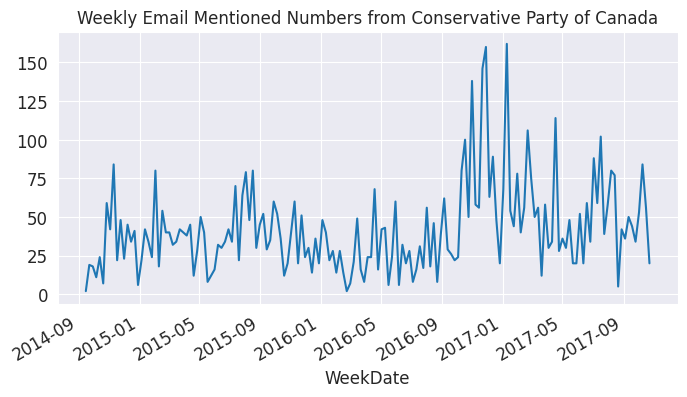

In [95]:
cp_perweek.plot(title = 'Weekly Email Mentioned Numbers from Conservative Party of Canada')

In [128]:
cp_mention_top20 = cp_df['email_mentioned_person'].groupby(cp_df['email_mentioned_person']).count().sort_values(ascending = False).nlargest(20)
cp_mention_top20

email_mentioned_person
Justin Trudeau      1077
Trudeau              810
John                 697
Mike                 655
Harper               278
Justin Trudeau's     173
Stephen Harper       133
Dustin van Vugt      129
Andrew Scheer        117
Justin                98
Rona                  89
Jaime Girard          86
Cory Hann             82
Thomas Mulcair        74
Rona Ambrose          72
Andrew                67
Omar Khadr            49
Fred DeLorey          43
Irving Gerstein       34
Lisa Raitt            34
Name: email_mentioned_person, dtype: int64

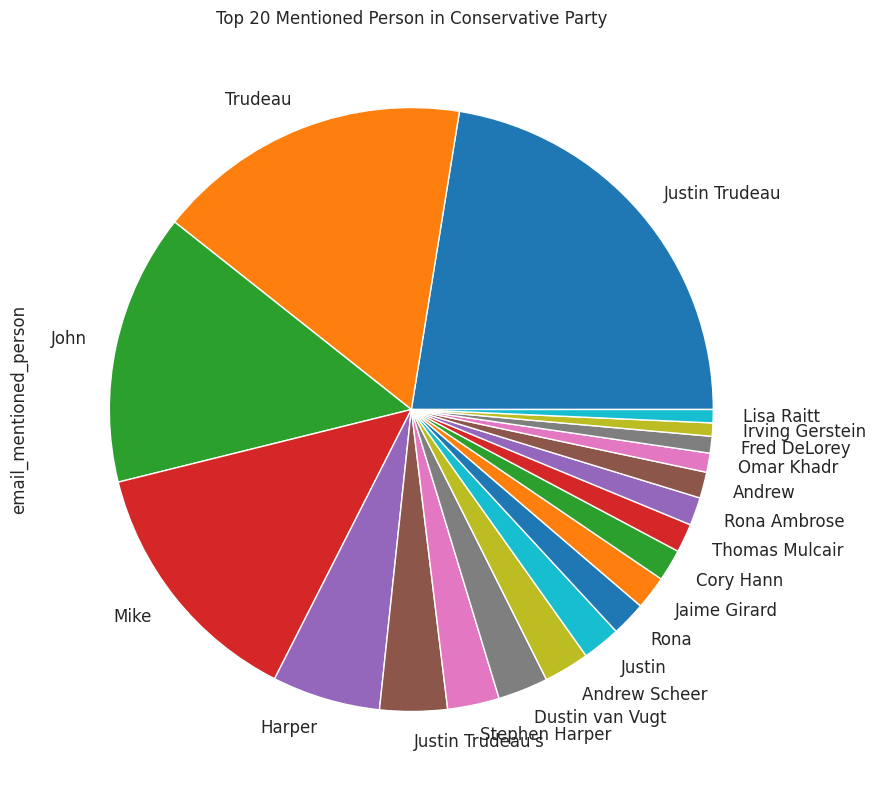

In [139]:
cp_mention_top20.plot.pie(figsize = (10,10),title = 'Top 20 Mentioned Person in Conservative Party')


- Liberal Party Data

In [86]:
lib_df['WeekDate'] =lib_df.apply(lambda row: row['date'] - dt.timedelta(days=row['date'].weekday()), axis=1)

lib_perweek = lib_df['WeekDate'].groupby(lib_df['WeekDate']).count()
lib_perweek()

WeekDate
2014-10-13    19
2014-10-20    88
2014-10-27    31
2014-11-03     4
2014-11-10    20
              ..
2017-09-25     1
2017-10-02    28
2017-10-09    17
2017-10-16    38
2017-10-23    30
Name: WeekDate, Length: 147, dtype: int64

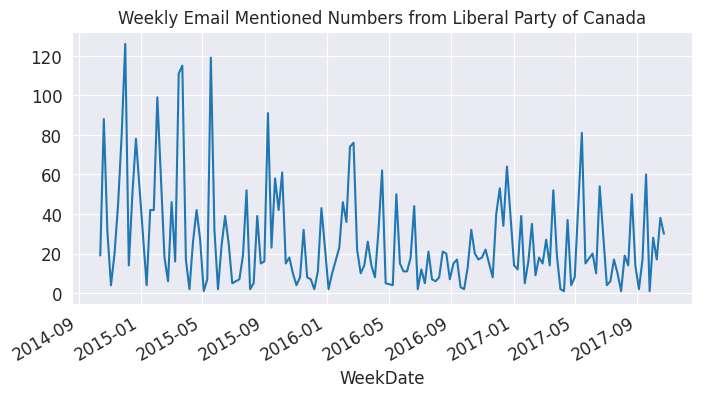

In [101]:
lib_perweek.plot(title = 'Weekly Email Mentioned Numbers from Liberal Party of Canada')

In [133]:

lib_mention_top20 = lib_df['email_mentioned_person'].groupby(lib_df['email_mentioned_person']).count().sort_values(ascending = False).nlargest(20)
lib_mention_top20

email_mentioned_person
Justin Trudeau       961
Mike                 667
Michael              454
Stephen Harper       109
Christina Topp        99
&rarr                 90
Harper                77
Stephen Harper's      56
Justin Trudeau's      54
Stephen Bronfman      49
Katie Telford         48
Anna Gainey           44
Justin                43
Team Trudeau          42
Trudeau               40
Braeden Caley         36
Andrew Scheer         35
Jeremy Broadhurst     32
Sophie                25
Jean Chrétien         24
Name: email_mentioned_person, dtype: int64

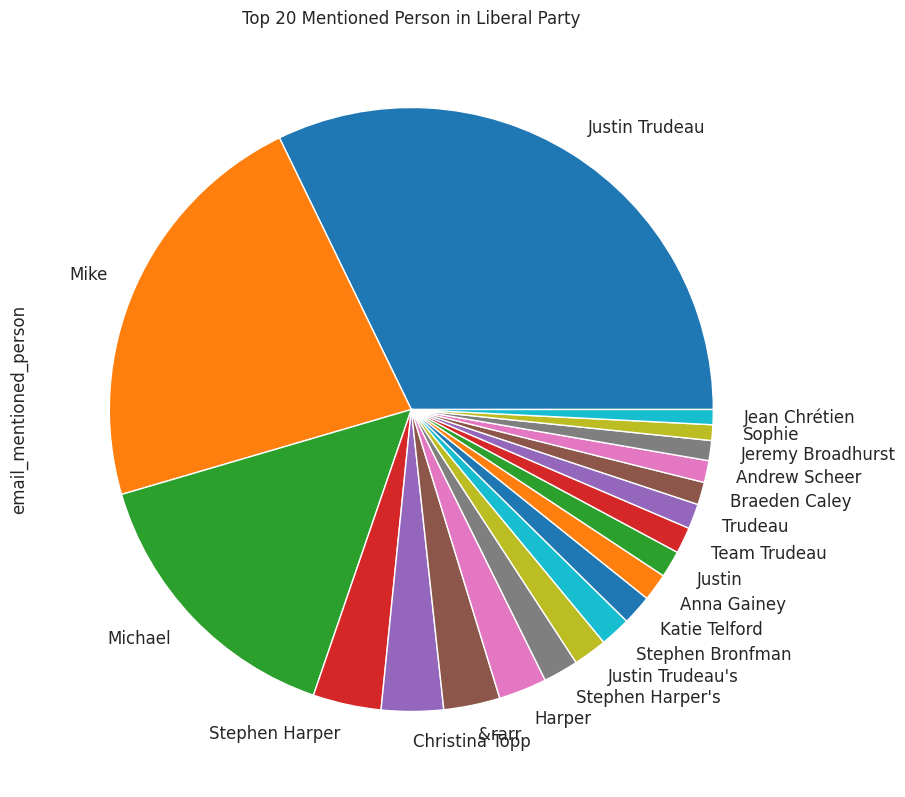

In [136]:
lib_mention_top20.plot.pie(figsize = (10,10),title = 'Top 20 Mentioned Person in Liberal Party')

- NDP Party data

In [87]:
ndp_df['WeekDate'] = ndp_df.apply(lambda row: row['date'] - dt.timedelta(days=row['date'].weekday()), axis=1)

ndp_perweek = ndp_df['WeekDate'].groupby(ndp_df['WeekDate']).count()
ndp_perweek

WeekDate
2014-09-08    52
2014-09-15    14
2014-09-22    60
2014-09-29    38
2014-10-06    60
              ..
2017-09-18    80
2017-09-25    86
2017-10-09    53
2017-10-16    38
2017-10-23     9
Name: WeekDate, Length: 137, dtype: int64

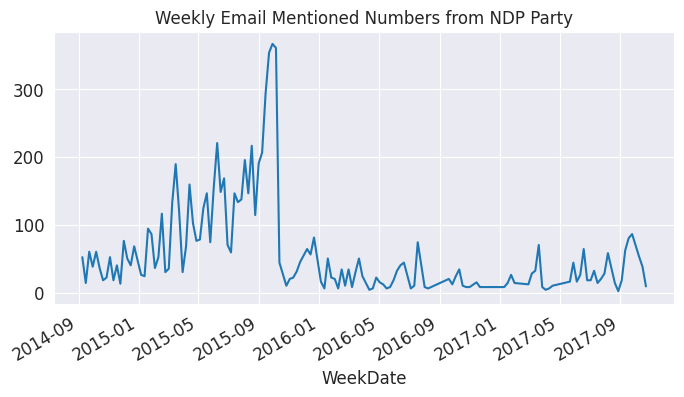

In [141]:
ndp_perweek.plot(title = 'Weekly Email Mentioned Numbers from NDP Party')

In [140]:
ndp_mention_top20 = ndp_df['email_mentioned_person'].groupby(ndp_df['email_mentioned_person']).count().sort_values(ascending = False).nlargest(20)
ndp_mention_top20

email_mentioned_person
Michael             928
Tom                 894
Mike                892
Tom Mulcair         789
Stephen Harper      723
Stephen Harper's    396
Harper              230
Dave                191
Dave Hare           190
Anne McGrath        186
Anne                181
Tom Mulcair's        76
Rebecca              75
Rebecca Blaikie      71
Megan Leslie         69
Lucy Watson          69
Lucy                 67
Pratt                59
James Pratt          59
Bill C-51            58
Name: email_mentioned_person, dtype: int64

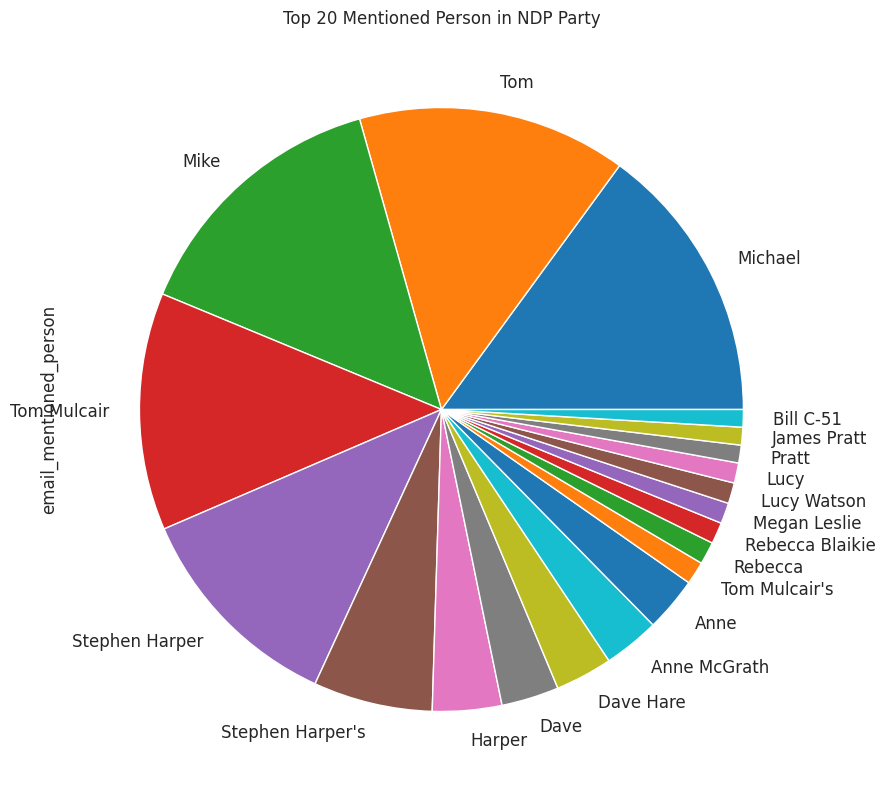

In [144]:
ndp_mention_top20.plot.pie(figsize = (10,10),title = 'Top 20 Mentioned Person in NDP Party')

### Discussion and Further works

###  Person name NER problems

- From the above results, NER results include such as 'Justin', 'Trudeau','Justin Trudeau'. From the common sense, these results should be combined into one person, but based on strickly language model definition, those should be seperated as different results. Solution for this problem should be train a small model to detect the context information to confirm all three name is one person.
-  "'s" problem
Results show the 'Stephen Harper's' and 'Stephen Harper' as different results.
This is easy to fix and just add one line to replace 's to ' ' in the email text, but I still left these result here to show the Stanza library's limitations
- Stanza vs Spacy
Both Stanza and Spacy are good NLP libraries, but Stanza has more acuracy results. Stanza is a collection of accurate and efficient tools for the linguistic analysis of many human languages. Starting from raw text to syntactic analysis and entity recognition, Stanza brings state-of-the-art NLP models to languages of your choosing.
#### For example:
- **input** :Corporate Nathan\n Cirillo. \\
- **SpaCy**: only detect **Corporate** Nathan \\
- **Stanza**: **Nathan\n Cirillo**



### Further works

- Extended work for email text, which includes text classification and sentiment analysis. The following basic NLP pipeline function for clean the text data function has been provided if need further works

In [1]:
#remove punctuations
def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

def remove_stopwords(text, STOPWORDS):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

def stem_words(text, stemmer):
    return " ".join([stemmer.stem(word) for word in text.split()])

def remove_freqwords(text, FREQWORDS):
    """custom function to remove the frequent words"""
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

def lemmatize_words(text, lemmatizer, wordnet_map ):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

def clean_review(text):
    clean_text = []
    for w in word_tokenize(text):
        idf['email_text'] = df['email_text'].apply(lambda x: remove_punct(x))
STOPWORDS = set(", ".join(stopwords.words('english')))


In [2]:
df['non_stop_emailtext'] = df['email_text'].apply(lambda x: remove_stopwords(x, STOPWORDS))

df['stemmed_emailtext'] = df['non_stop_emailtext'].apply(lambda x: stem_words(x,PorterStemmer()))

#remove frequent words 
fre_count = Counter()
for phrase in df["stemmed_emailtext"].values:
    for word in phrase.split():
        fre_count[word] += 1
        
fre_count.most_common(10)

fre_words = set([word for (word, count) in fre_count.most_common(10)])
df["non_freq_emailtext"] = df["stemmed_emailtext"].apply(lambda x: remove_freqwords(x, fre_words))f w.lower() not in stop:
            pos = pos_tag([w])
            new_w = lemmatizer.lemmatize(w, pos=get_simple_pos(pos[0][1]))
            clean_text.append(new_w)
    return clean_text

def join_text(text):
    return " ".join(text)
